In [2]:
import pygame
import math
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import pickle
import matplotlib.pyplot as plt


# =========== Configuration and Costraints ===========

WIDTH, HEIGHT = 1200, 800
TRACK_WIDTH = 50
FPS = 60

# =========== Track definition ===========

# Easy track 1
easy_1 = [(200,100),(300,100),(400,100),(500,100),(600,100),(700,100),(800,100),(900,100),(1000,100),(1100,100),(1100,200),(1100,300),(1100,400),(1100,500),(1100,600),(1100,700),(1000,700),(900,700),(900,600),(900,500),(900,400),(900,300),(800,300),(700,300),(600,300),(500,300),(400,300),(300,300),(300,400),(300,500),(300,600),(300,700),(200,700),(100,700),(100,600),(100,500),(100,400),(100,300),(100,200),(100,100)]
circle_easy_1 = [(100,100),(1100,100),(1100,700),(900,700),(900,300),(300,300),(300,700),(100,700)]

# Easy track 2
easy_2 = [(300,500),(400,500),(500,500),(600,500),(700,500),(800,500),(900,500),(1000,500),(1100,500),(1100,500),(1100,600),(1100,700),(1000,700),(900,700),(800,700),(700,700),(600,700),(500,700),(400,700),(300,700),(200,700),(100,700),(100,600),(100,500),(100,400),(100,300),(100,200),(100,100),(200,100),(300,100),(300,200),(300,300),(300,400)]
circle_easy_2 = [(100,100),(300,100),(300,500),(1100,500),(1100,700),(100,700)]

# Hard track 1
hard_1 = [(200,100),(300,100),(400,100),(500,100),(500,200),(500,300),(600,300),(700,300),(700,200),(700,100),(800,100),(900,100),(1000,100),(1100,100),(1100,200),(1100,300),(1100,400),(1100,500),(1000,500),(900,500),(900,600),(900,700),(800,700),(700,700),(600,700),(500,700),(400,700),(300,700),(200,700),(100,700),(100,600),(100,500),(100,400),(100,300),(100,200),(100,100)]
circle_hard_1 = [(100,100),(500,100),(500,300),(700,300),(700,100),(1100,100),(1100,500),(900,500),(900,700),(100,700)]

# Hard track 2
hard_2 = [(400,100),(500,100),(600,100),(700,100),(800,100),(900,100),(1000,100),(1100,100),(1100,200),(1100,300),(1100,400),(1100,500),(1100,600),(1100,700),(1000,700),(900,700),(800,700),(700,700),(700,600),(700,500),(800,500),(900,500),(900,400),(900,300),(800,300),(700,300),(600,300),(500,300),(500,400),(500,500),(400,500),(300,500),(300,600),(300,700),(200,700),(100,700),(100,600),(100,500),(100,400),(100,300),(200,300),(300,300),(300,200),(300,100)]
circle_hard_2 = [(300,100),(1100,100),(1100,700),(700,700),(700,500),(900,500),(900,300),(500,300),(500,500),(300,500),(300,700),(100,700),(100,300),(300,300)]

# Track selection
train_circuit = hard_2
circle_train_circuit = circle_hard_2

test_circuit = hard_1
circle_test_circuit = circle_hard_1

# =========== Enviroment Class ===========

class CarEnv:
    def __init__(self, track_points, circle_points):
        pygame.init()
        self.screen = pygame.display.set_mode((WIDTH, HEIGHT))
        self.clock = pygame.time.Clock()
        self.font = pygame.font.SysFont("Arial", 20)

        self.points = track_points
        self.circles = circle_points
        
        # Create track and checkpoints
        self.track_surface = self._create_track()
        
        # Checkpoints configuration
        self.chk_size = TRACK_WIDTH*2 + 5 
        self.half_chk = self.chk_size // 2 

        # Time step
        self.dt = 0.5
        
        self.reset()

    def reset(self):
        #
        # =========== Reset the car to the starting position and clears state ===========
        #

        self.x, self.y = self.points[0]
        
        # Initialize car angle torwards the second checkpoint
        dx = self.points[1][0] - self.points[0][0]
        dy = self.points[1][1] - self.points[0][1]
        self.angle = math.atan2(dy, dx)
        
        self.velocity = 0
        self.radars = []
        self.alive = True

        # Checkpoint management
        self.current_chk = 1 
        self.laps = 0
        self.steps_since_chk = 0

        # Initialize straight
        self.last_action = 2
        
        return self.get_state()

    def step(self, action_idx):
        #
        # =========== Executes one time step ===========
        #

        # Action processing
        steer = 0
        if action_idx == 0: steer = -35
        elif action_idx == 1: steer = -15
        elif action_idx == 2: steer = 0
        elif action_idx == 3: steer = 15
        elif action_idx == 4: steer = 35
        
        # =========== Physics update ===========

        # Constant aceleration to max velocity
        self.velocity += 1.0 * self.dt
        self.velocity = min(self.velocity, 12) 
        
        # Angular velocity
        angular_velocity = (self.velocity / 30) * math.tan(math.radians(steer))
        self.angle += angular_velocity * self.dt
        
        # Update position
        self.x += math.cos(self.angle) * self.velocity * self.dt
        self.y += math.sin(self.angle) * self.velocity * self.dt
        
        self.steps_since_chk += 1
        reward = 0
        done = False
        
        # =========== Rewards ===========
        
        # Penalty for changing direction
        change_magnitude = abs(action_idx - self.last_action)
        stability_penalty = change_magnitude * -0.1
        reward += stability_penalty
    
        self.last_action = action_idx

        # Collision detection
        if self._check_collision():
            self.alive = False
            reward += -10000
            done = True
        else:
            reward += -0.01 # Small time penality
            
        # Checkpoint verification
        target_x, target_y = self.points[self.current_chk]
        
        diff_x = abs(self.x - target_x)
        diff_y = abs(self.y - target_y)
        
        if diff_x < self.half_chk and diff_y < self.half_chk:
            reward += 100 
            self.current_chk += 1
            self.steps_since_chk = 0
            
            # lap completion logic
            if self.current_chk >= len(self.points):
                self.current_chk = 0
                self.laps += 1
                
                # End episode after the first lap
                if self.laps == 1:
                    done = True
                
        # Timeout
        if self.steps_since_chk > 400:
            done = True
            reward += -1000

        return self.get_state(), reward, done

    def get_state(self):
        #
        # =========== Radar simulation ===========
        #

        self.radars = []
        readings = []
        angles = [-90, -45, 0, 45, 90]
        
        for a in angles:
            radar_angle = self.angle + math.radians(a)
            dist = 0
            # Raycast up to 200 pixel
            for i in range(10, 200, 10):
                lx = int(self.x + math.cos(radar_angle) * i)
                ly = int(self.y + math.sin(radar_angle) * i)

                # Check bounds and track color (black = off-track)
                if lx < 0 or lx >= WIDTH or ly < 0 or ly >= HEIGHT or self.track_surface.get_at((lx, ly))[0] < 50:
                    dist = i
                    break
                dist = i

            self.radars.append((lx, ly, dist))
            # Normalize distance to [0, 1] for the neural network
            readings.append(dist / 200.0) 
            
        return np.array(readings, dtype=np.float32)

    def render(self, mode_text=""):
        #
        # =========== Pygame render ===========
        #

        for event in pygame.event.get():
            if event.type == pygame.QUIT: 
                pygame.quit(); 
                return False

        # Clear screen
        self.screen.fill((0, 0, 0))
        self.screen.blit(self.track_surface, (0, 0))
        
        # Draw checkpoints
        for i, point in enumerate(self.points):
            cx, cy = point 
            
            top_left_x = cx - self.half_chk
            top_left_y = cy - self.half_chk
            
            if i == self.current_chk:
                color = (0, 255, 0) # Green for active checkpoint
                width = 3
            else:
                color = (100, 0, 0) # red for the others
                width = 1
            
            rect = pygame.Rect(top_left_x, top_left_y, self.chk_size, self.chk_size)
            pygame.draw.rect(self.screen, color, rect, width)

        # Draw car
        car_surf = pygame.Surface((30, 15), pygame.SRCALPHA)
        pygame.draw.rect(car_surf, (50, 200, 255), (0, 0, 30, 15))
        rot_car = pygame.transform.rotate(car_surf, -math.degrees(self.angle))
        rect = rot_car.get_rect(center=(self.x, self.y))
        self.screen.blit(rot_car, rect)
        
        # Draw Radar lines
        for (lx, ly, dist) in self.radars:
            color = (255, 50, 50) if dist < 50 else (50, 255, 50)
            pygame.draw.line(self.screen, color, (self.x, self.y), (lx, ly), 1)

        # Draw HUD
        info = f"{mode_text} | Laps: {self.laps} | Next CP: {self.current_chk}"
        self.screen.blit(self.font.render(info, True, (255, 255, 255)), (10, 10))

        pygame.display.flip()
        self.clock.tick(FPS)
        return True

    def _create_track(self):
        #
        # =========== Generate the track surface ===========
        #

        surf = pygame.Surface((WIDTH, HEIGHT))
        surf.fill((0, 0, 0)) # Off track is black

        # Draw track lines (white)
        pygame.draw.lines(surf, (255, 255, 255), True, self.points, TRACK_WIDTH*2)

        # Draw smooth corners
        for circle in self.circles:
            pygame.draw.circle(surf,(255, 255, 255), circle, TRACK_WIDTH)
            
        return surf

    def _check_collision(self):
        #
        # =========== Check if the car center is on a black pixel (off-track) ===========
        #

        try:
            if self.track_surface.get_at((int(self.x), int(self.y)))[0] < 50: return True
        except: 
            return True # Collision if out of bound
        return False
    
def plot_rewards(rewards, title="Training Reward Evolution"):
    plt.figure(figsize=(12, 6))
    
    # Plot raw data
    plt.plot(rewards, alpha=0.3, color='gray', label='Episode Reward')
    
    # Plot moving avarage
    window_size = 50
    if len(rewards) >= window_size:
        moving_avg = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
        plt.plot(moving_avg, color='red', linewidth=2, label=f'Moving Avg ({window_size} eps)')
    
    plt.title(title)
    plt.xlabel("Episode Number")
    plt.ylabel("Total Reward")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_lap_times_interpolated(lap_times, title="Lap Times"):
    plt.figure(figsize=(12, 6))
    
    data = np.array(lap_times, dtype=np.float64)
    
    # Extract only valid lap times
    valid_indices = np.where(np.isfinite(data))[0]
    valid_times = data[valid_indices]
    
    if len(valid_times) > 1:
        # Scatter valid laps
        plt.scatter(valid_indices, valid_times, color='blue', alpha=0.6, s=20, label='Successful Laps')
        
        # Connect valid points
        plt.plot(valid_indices, valid_times, color='cyan', alpha=0.4, linewidth=1, label='Lap sequence')
        
        # Polynomial trend line (3rd degree)
        # try:
        #     z = np.polyfit(valid_indices, valid_times, 3) 
        #     p = np.poly1d(z)
            
        #     plt.plot(valid_indices, p(valid_indices), color='orange', linewidth=3, linestyle='-', label='Polynomial trend')
        # except:
        #     pass
            
        # Average Time Line
        avg_time = np.mean(valid_times)
        plt.axhline(y=avg_time, color='red', linestyle='-.', alpha=0.8, label=f'Avarage Time: {avg_time:.2f}s')

        # Standard Deviation area
        std_val = np.std(valid_times)
        plt.axhspan(avg_time - std_val, avg_time + std_val, color='blue', alpha=0.15, label=f'Std Deviation (±{std_val:.2f}s)')

        # Absolute record
        best_time = np.min(valid_times)
        plt.axhline(y=best_time, color='green', linestyle='--', alpha=0.8, label=f'Absolute Record: {best_time:.2f}s')

    plt.xlim(0,len(lap_times))

    plt.title(title)
    plt.xlabel("Episods")
    plt.ylabel("Time (Seconds)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

pygame 2.6.1 (SDL 2.28.4, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Q-Learning

In [12]:
def discretize_state(readings):
    #
    # =========== Convert continuous radar reading intro discrete state to reduce the q-table ===========
    #
    
    state = []
    # 0=close, 1=medium, 2=far
    for r in readings:
        if r < 0.3: state.append(0)   
        elif r < 0.6: state.append(1) 
        else: state.append(2)         
    return tuple(state)

def run_q_learning():
    #
    # =========== Q-learning training loop ===========
    #

    print("Avvio Q-Learning...")
    env = CarEnv(train_circuit,circle_train_circuit)
    
    # Initialization empty q-table 
    q_table = {}

    total_reward_history = []
    lap_times_history = []
    
    # Hyperparameters
    episodes = 1000
    alpha = 0.1    # Learning Rate
    gamma = 0.99   # Discount Factor
    epsilon = 1.0  # Exploration
    min_epsilon = 0.03
    decay_rate = 0.995
    
    rendering = False # Start with render On or Off
    
    for ep in range(episodes):
        raw_state = env.reset()
        state = discretize_state(raw_state)
        done = False
        total_reward = 0
        steps = 0
        
        while not done:
            # Stop if the window is closed
            if not pygame.get_init():
                return

            # Render logic
            # Pres R to disable/enable rendering
            keys = pygame.key.get_pressed()
            for e in pygame.event.get():
                if e.type == pygame.KEYDOWN and e.key == pygame.K_r:
                    rendering = not rendering
                if e.type == pygame.QUIT: pygame.quit(); return

            if rendering:
                if not env.render(f"Q-Learning Ep: {ep} Eps: {epsilon:.2f}"): return

            # Initialize state in the q-table if encountered for the first time
            if state not in q_table:
                q_table[state] = [0.0, 0.0, 0.0, 0.0, 0.0] # Actions
            
            if random.random() < epsilon:
                # Explore
                action = random.randint(0, 4)
            else: 
                # Exploit
                vals = q_table[state]
                max_val = max(vals)
                # Tie braking
                actions_with_max = [i for i, v in enumerate(vals) if v == max_val]
                action = random.choice(actions_with_max)
            
            # Step
            raw_next, reward, done = env.step(action)
            next_state = discretize_state(raw_next)
            
            # Q-table update
            if next_state not in q_table:
                q_table[next_state] = [0.0, 0.0, 0.0, 0.0, 0.0]
                
            old_value = q_table[state][action]
            next_max = max(q_table[next_state])
            
            # Bellman equation
            new_value = old_value + alpha * (reward + gamma * next_max - old_value)
            q_table[state][action] = new_value
            
            state = next_state
            total_reward += reward

            steps += 1
            
        # Decay exploration rate
        epsilon = max(min_epsilon, epsilon * decay_rate)

        total_reward_history.append(total_reward)
        if ep % 50:
            print(f"Episode {ep} | Reward: {total_reward:.1f} | Epsilon: {epsilon:.2f}")

        # Simualted time calculation
        if env.laps > 0:
            simulated_time = steps * env.dt
            lap_times_history.append(simulated_time)
        else:
            # If lap not completed time = nan
            lap_times_history.append(np.nan)
            
    print("Training Q-Learning finished.")

    # Save the trained table
    with open("q_table_model.pkl", "wb") as f:
        pickle.dump(q_table, f)
    print("Q-Learning model saved")

    pygame.quit()

    return total_reward_history, lap_times_history

def test_ql_new_track(rendering):
    #
    # =========== Q-learning test ===========
    #

    print("TESTING ON CIRCUIT 2 (Never seen)...")
    env = CarEnv(test_circuit,circle_test_circuit) # Test circuit
    
    # Load the trained model
    with open("q_table_model.pkl", "rb") as f:
        q_table = pickle.load(f)
        
    state = discretize_state(env.reset())
    done = False
    step = 0
    
    while not done:
        step += 1
        if rendering:
            if not env.render("TEST MODE - Q-Learning"): return
        
        # No exploration
        if state in q_table:
            vals = q_table[state]
            action = np.argmax(vals) 
        else:
            # if action not in the table go straight 
            action = 2 
            
        raw_next, reward, done = env.step(action)
        state = discretize_state(raw_next)

    # Simulated time calculation
    if env.laps > 0:
        simulated_time = step * env.dt
        print(f"LAP COMPLETED in {simulated_time:.1f}s")
    else:
        simulated_time = np.nan
        print("LAP NOT COMPLETED")

    pygame.quit()

    return simulated_time

Avvio Q-Learning...
Episode 1 | Reward: -9905.8 | Epsilon: 0.99
Episode 2 | Reward: -9807.5 | Epsilon: 0.99
Episode 3 | Reward: -9710.1 | Epsilon: 0.98
Episode 4 | Reward: -9907.0 | Epsilon: 0.98
Episode 5 | Reward: -9613.8 | Epsilon: 0.97
Episode 6 | Reward: -9613.1 | Epsilon: 0.97
Episode 7 | Reward: -9905.9 | Epsilon: 0.96
Episode 8 | Reward: -9807.8 | Epsilon: 0.96
Episode 9 | Reward: -9711.0 | Epsilon: 0.95
Episode 10 | Reward: -9710.6 | Epsilon: 0.95
Episode 11 | Reward: -9709.9 | Epsilon: 0.94
Episode 12 | Reward: -9615.2 | Epsilon: 0.94
Episode 13 | Reward: -9806.4 | Epsilon: 0.93
Episode 14 | Reward: -9615.5 | Epsilon: 0.93
Episode 15 | Reward: -9319.1 | Epsilon: 0.92
Episode 16 | Reward: -9322.9 | Epsilon: 0.92
Episode 17 | Reward: -9709.5 | Epsilon: 0.91
Episode 18 | Reward: -9616.7 | Epsilon: 0.91
Episode 19 | Reward: -9807.0 | Epsilon: 0.90
Episode 20 | Reward: -9807.3 | Epsilon: 0.90
Episode 21 | Reward: -9225.1 | Epsilon: 0.90
Episode 22 | Reward: -9514.0 | Epsilon: 0.89

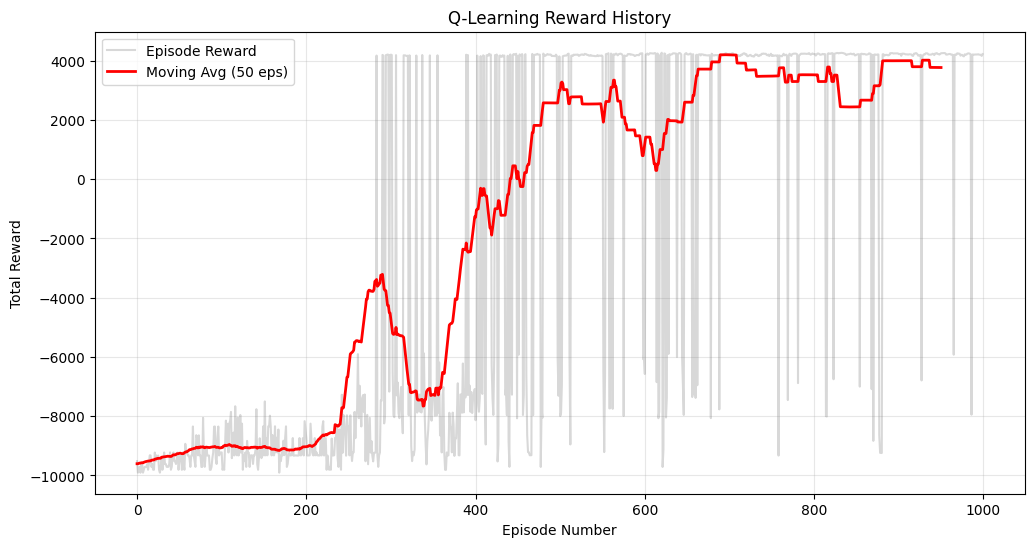

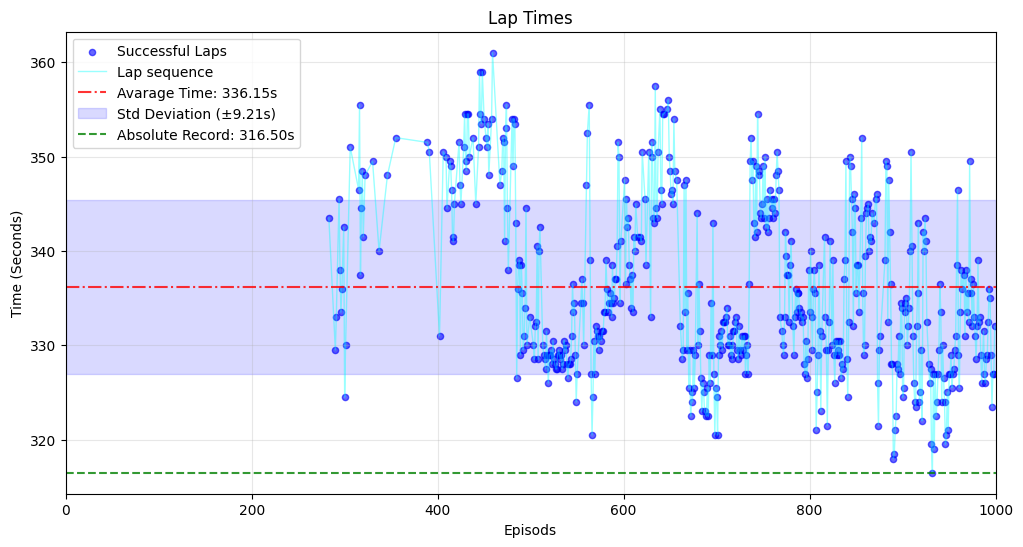

In [13]:
rewards, times  = run_q_learning()

plot_rewards(rewards, title="Q-Learning Reward History")

plot_lap_times_interpolated(times)

In [14]:
test_ql_new_track(True)


TESTING ON CIRCUIT 2 (Never seen)...
LAP COMPLETED in 275.0s


275.0

# DQN

In [6]:
class DQN(nn.Module):
    #
    # =========== DQN Architecture ===========
    #
    
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),        # Input layer
            nn.ReLU(),                        # Actiavtion function
            nn.Linear(128, 128),              # Hidden layer
            nn.ReLU(),
            nn.Linear(128, output_dim)        # Output layer
        )
        
    def forward(self, x):
        return self.net(x)

def run_dqn():
    #
    # =========== DQN training loop ===========
    #

    print("Start DQN...")

    total_reward_history = []
    lap_times_history = []
    env = CarEnv(train_circuit,circle_train_circuit)
    
    # Network Initialization
    policy_net = DQN(5, 5) # 5 Radar and 5 Actions
    target_net = DQN(5, 5)

    # Sync target network initially
    target_net.load_state_dict(policy_net.state_dict())
    
    # Optimizer Adam and MSE loss function
    optimizer = optim.Adam(policy_net.parameters(), lr=0.0005)
    loss_fn = nn.MSELoss()

    # Memory
    memory = deque(maxlen=50000)
    
    # Hyperparameters
    episodes = 1000
    epsilon = 1.0 # Exploration rate
    min_epsilon = 0.03
    batch_size = 512 # Number of experiences to sample per training step
    gamma = 0.99 # Discount factor
    decay_rate = 0.995

    train_frequency = 5 # Train every 5 steps
    rendering = False
    steps_total = 0 # Global step counter across epochs

    target_update_freq = 50

    for ep in range(episodes):
        state = env.reset()
        state_t = torch.FloatTensor(state).unsqueeze(0)

        done = False
        total_reward = 0
        steps_ep = 0
        
        while not done:
            steps_total += 1
            steps_ep += 1 
            
            # Render logic
            # Pres R to disable/enable rendering
            keys = pygame.key.get_pressed()
            for e in pygame.event.get():
                if e.type == pygame.KEYDOWN and e.key == pygame.K_r:
                    rendering = not rendering
                if e.type == pygame.QUIT: pygame.quit(); return

            if rendering:
                if not env.render(f"DQN Ep: {ep} Eps: {epsilon:.2f}"): return

            if random.random() < epsilon:
                # Exploration
                action = random.randint(0, 4)
            else:
                with torch.no_grad():
                    # Exploitation
                    q_values = policy_net(state_t)
                    action = torch.argmax(q_values).item()
            
            # Step
            next_state, reward, done = env.step(action)
            next_state_t = torch.FloatTensor(next_state).unsqueeze(0)
            
            # Memory
            memory.append((state_t, action, reward, next_state_t, done))

            state_t = next_state_t
            total_reward += reward
            
            # training step
            if len(memory) > batch_size and steps_total % train_frequency == 0:
                
                # Sample a random batch from memory
                batch = random.sample(memory, batch_size)
                states, actions, rewards, next_states, dones = zip(*batch)
                
                # Prepare batches for pytorch
                states_b = torch.cat(states)
                next_states_b = torch.cat(next_states)
                
                actions_b = torch.tensor(actions).unsqueeze(1)
                rewards_b = torch.tensor(rewards, dtype=torch.float32)
                dones_b = torch.tensor(dones, dtype=torch.float32)
                
                # Q-values calculation
                curr_Q = policy_net(states_b).gather(1, actions_b).squeeze()
                
                # Target calculation
                with torch.no_grad():
                    next_Q = target_net(next_states_b).max(1)[0]
                    target_Q = rewards_b + (gamma * next_Q * (1 - dones_b))
                
                # Compute loss and backpropagate
                loss = loss_fn(curr_Q, target_Q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        total_reward_history.append(total_reward)

        # Simulated time calculation
        if env.laps > 0:
            simulated_time = steps_ep * env.dt
            lap_times_history.append(simulated_time)
        else:
            # If lap not completed time = nan
            lap_times_history.append(np.nan)

        # Decay exploration
        epsilon = max(min_epsilon, epsilon * decay_rate)
        
        # Update target netwrok
        if ep % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())
            print(f"Ep {ep} | Reward: {total_reward:.1f} | Epsilon: {epsilon:.2f}")

    print("Training DQN finished.")

    # Save the trained model weights
    torch.save(policy_net.state_dict(), "dqn_model.pth")
    print("DQN model saved")

    pygame.quit()

    return total_reward_history, lap_times_history

def test_dqn_new_track(rendering):
    #
    # =========== DQN Testing ===========
    #

    print("TESTING DQN SU CIRCUITO 2...")
    env = CarEnv(test_circuit,circle_test_circuit)
    
    # Load the trained model
    model = DQN(5, 5)
    model.load_state_dict(torch.load("dqn_model.pth"))
    model.eval() # Just evaluation, no more training
    
    state = env.reset()
    state_t = torch.FloatTensor(state)
    done = False
    step = 0
    
    while not done:
        step += 1
        if rendering:
            if not env.render("TEST MODE - DQN"): return
        
        with torch.no_grad():
            q_values = model(state_t)
            action = torch.argmax(q_values).item()
            
        raw_next, reward, done = env.step(action)
        state_t = torch.FloatTensor(raw_next)

    # Simulated time calculation
    if env.laps > 0:
        simulated_time = step * env.dt
        print(f"LAP COMPLETED in {simulated_time:.1f}s")
    else:
        simulated_time = np.nan
        print("LAP NOT COMPLETED")
            
    pygame.quit()

    return simulated_time

Start DQN...
Ep 0 | Reward: -9807.9 | Epsilon: 0.99
Ep 50 | Reward: -9906.8 | Epsilon: 0.77
Ep 100 | Reward: -9807.0 | Epsilon: 0.60
Ep 150 | Reward: -9711.6 | Epsilon: 0.47
Ep 200 | Reward: -9904.4 | Epsilon: 0.37
Ep 250 | Reward: -9802.6 | Epsilon: 0.28
Ep 300 | Reward: -9308.2 | Epsilon: 0.22
Ep 350 | Reward: 4247.7 | Epsilon: 0.17
Ep 400 | Reward: 4223.5 | Epsilon: 0.13
Ep 450 | Reward: 4241.5 | Epsilon: 0.10
Ep 500 | Reward: 4248.3 | Epsilon: 0.08
Ep 550 | Reward: 4249.1 | Epsilon: 0.06
Ep 600 | Reward: 4245.3 | Epsilon: 0.05
Ep 650 | Reward: 4240.5 | Epsilon: 0.04
Ep 700 | Reward: 4234.4 | Epsilon: 0.03
Ep 750 | Reward: 4244.8 | Epsilon: 0.03
Ep 800 | Reward: 4238.7 | Epsilon: 0.03
Ep 850 | Reward: 4247.7 | Epsilon: 0.03
Ep 900 | Reward: 4245.1 | Epsilon: 0.03
Ep 950 | Reward: 4246.6 | Epsilon: 0.03
Training DQN finished.
DQN model saved


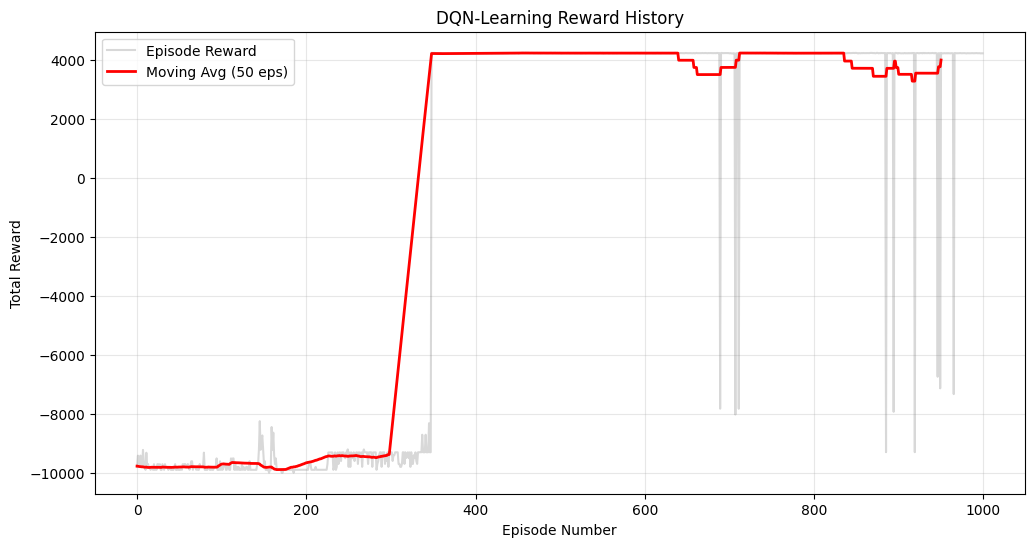

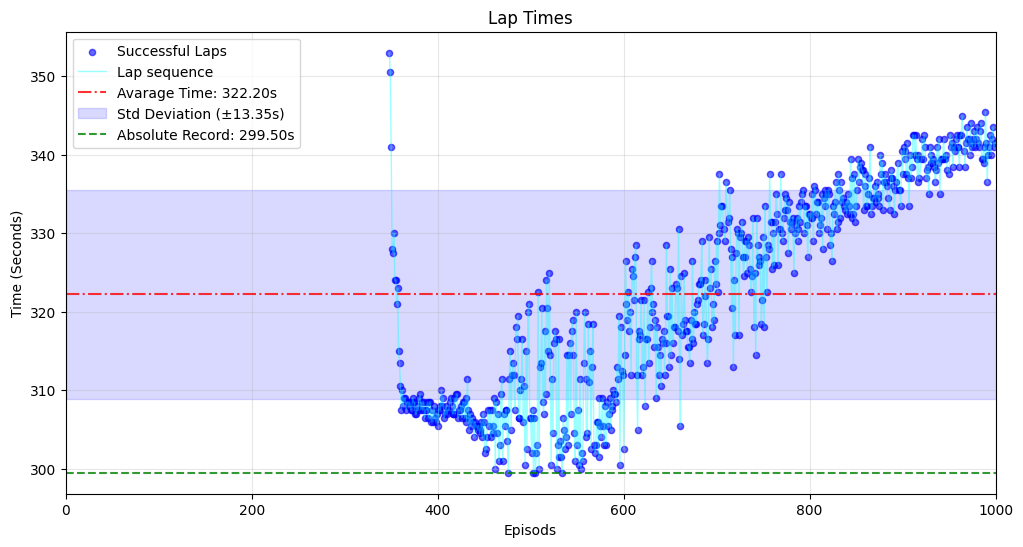

In [7]:
rewards, times = run_dqn()

plot_rewards(rewards, title="DQN-Learning Reward History")

plot_lap_times_interpolated(times)

In [10]:
test_dqn_new_track(True)

TESTING DQN SU CIRCUITO 2...


C:\Users\czzdv\AppData\Local\Temp\ipykernel_40324\740758486.py:167: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("dqn_model.pth"))


LAP COMPLETED in 281.0s


281.0

-----------------------------------------------epochs : 0--------------------------------------------
Avvio Q-Learning...
Episode 1 | Reward: -9905.4 | Epsilon: 0.99
Episode 2 | Reward: -9322.8 | Epsilon: 0.99
Episode 3 | Reward: -9709.2 | Epsilon: 0.98
Episode 4 | Reward: -9708.9 | Epsilon: 0.98
Episode 5 | Reward: -9710.0 | Epsilon: 0.97
Episode 6 | Reward: -9807.6 | Epsilon: 0.97
Episode 7 | Reward: -9709.3 | Epsilon: 0.96
Episode 8 | Reward: -9709.8 | Epsilon: 0.96
Episode 9 | Reward: -9905.5 | Epsilon: 0.95
Episode 10 | Reward: -9904.1 | Epsilon: 0.95
Episode 11 | Reward: -9616.0 | Epsilon: 0.94
Episode 12 | Reward: -9612.6 | Epsilon: 0.94
Episode 13 | Reward: -9808.4 | Epsilon: 0.93
Episode 14 | Reward: -9420.5 | Epsilon: 0.93
Episode 15 | Reward: -9418.4 | Epsilon: 0.92
Episode 16 | Reward: -9807.3 | Epsilon: 0.92
Episode 17 | Reward: -9515.8 | Epsilon: 0.91
Episode 18 | Reward: -9416.7 | Epsilon: 0.91
Episode 19 | Reward: -9709.7 | Epsilon: 0.90
Episode 20 | Reward: -9906.0 | E

C:\Users\czzdv\AppData\Local\Temp\ipykernel_40324\740758486.py:167: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("dqn_model.pth"))


LAP COMPLETED in 263.5s
-----------------------------------------------epochs : 1--------------------------------------------
Avvio Q-Learning...
Episode 1 | Reward: -9805.9 | Epsilon: 0.99
Episode 2 | Reward: -9809.8 | Epsilon: 0.99
Episode 3 | Reward: -9713.4 | Epsilon: 0.98
Episode 4 | Reward: -9710.6 | Epsilon: 0.98
Episode 5 | Reward: -9905.1 | Epsilon: 0.97
Episode 6 | Reward: -9808.4 | Epsilon: 0.97
Episode 7 | Reward: -9614.4 | Epsilon: 0.96
Episode 8 | Reward: -9808.7 | Epsilon: 0.96
Episode 9 | Reward: -9710.2 | Epsilon: 0.95
Episode 10 | Reward: -9323.6 | Epsilon: 0.95
Episode 11 | Reward: -9615.9 | Epsilon: 0.94
Episode 12 | Reward: -9903.9 | Epsilon: 0.94
Episode 13 | Reward: -9905.8 | Epsilon: 0.93
Episode 14 | Reward: -9417.4 | Epsilon: 0.93
Episode 15 | Reward: -9804.6 | Epsilon: 0.92
Episode 16 | Reward: -9905.6 | Epsilon: 0.92
Episode 17 | Reward: -9905.3 | Epsilon: 0.91
Episode 18 | Reward: -9808.0 | Epsilon: 0.91
Episode 19 | Reward: -9904.9 | Epsilon: 0.90
Episode 

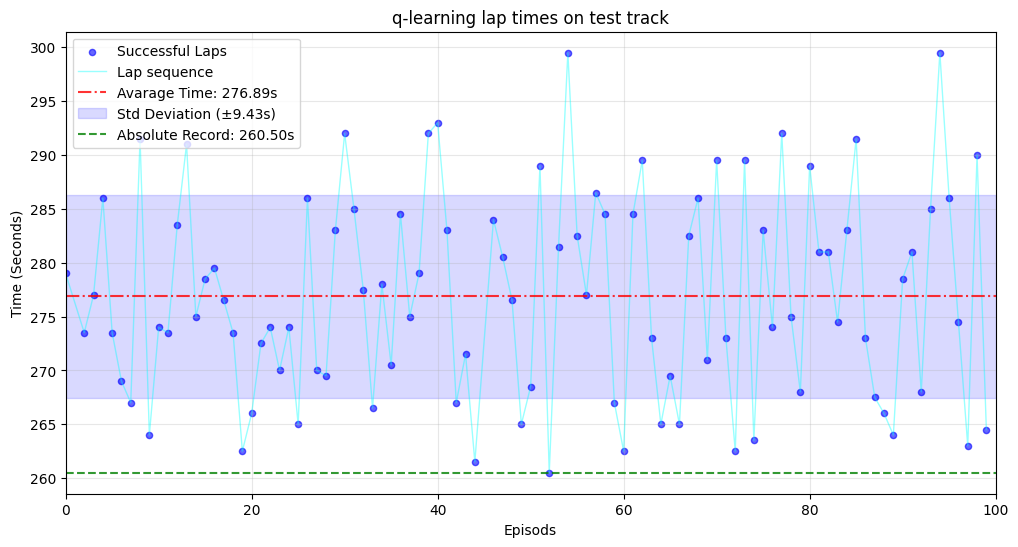

Q-learning succesfully completed the test track: 98 times out of 100 try


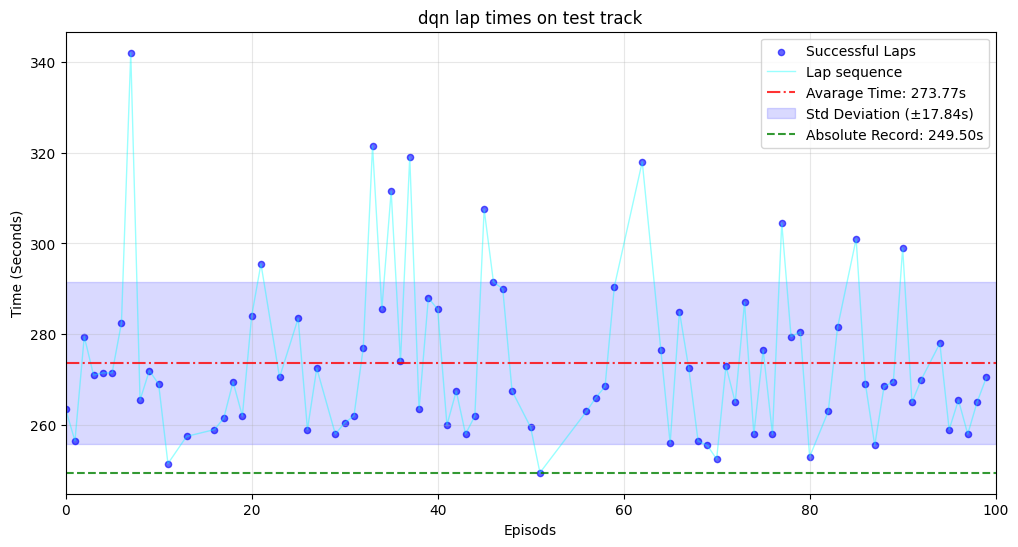

DQN succesfully completed the test track: 83 times out of 100 try


In [11]:
q_learning = []
dqn = []
valid_indices_q = 0
valid_indices_dqn = 0

epochs = 100

for ep in range(epochs):
    print(f"-----------------------------------------------epochs : {ep}--------------------------------------------")
    _, _  = run_q_learning()
    q_learning.append(test_ql_new_track(False))

    _, _ = run_dqn()
    dqn.append(test_dqn_new_track(False))

plot_lap_times_interpolated(q_learning, "q-learning lap times on test track")
valid_indices_q = np.where(np.isfinite(q_learning), True, False)
print(f"Q-learning succesfully completed the test track: {np.sum(valid_indices_q)} times out of {epochs} try")

plot_lap_times_interpolated(dqn, "dqn lap times on test track")
valid_indices_dqn = np.where(np.isfinite(dqn), True, False)
print(f"DQN succesfully completed the test track: {np.sum(valid_indices_dqn)} times out of {epochs} try")